# Training Section

C:\Users\Arsha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Arsha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Arsha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Arsha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Arsha\anaconda3\lib\site-packages\sklearn\neural_network\_multi

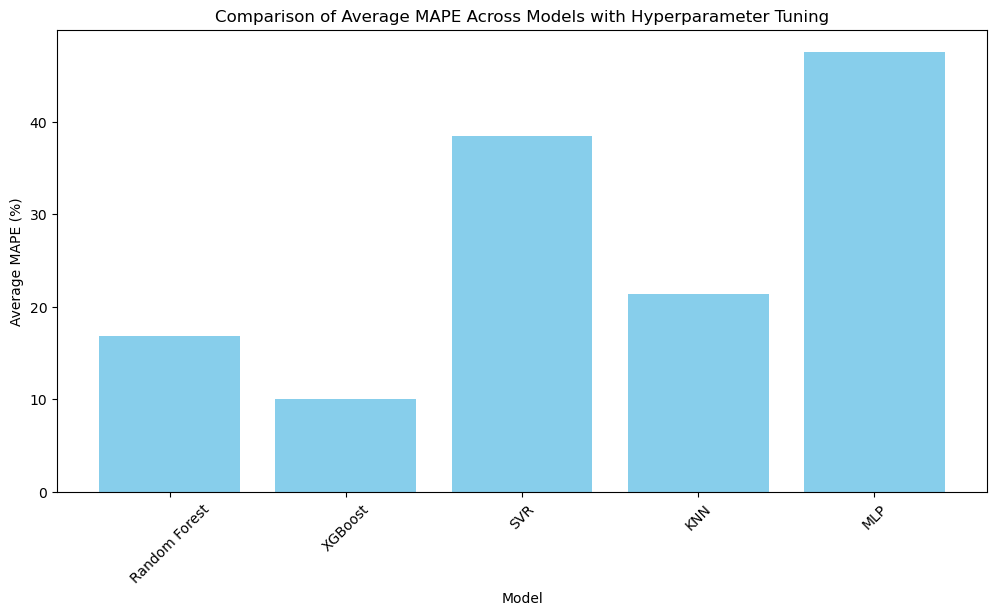

In [1]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    ape = 100 * np.abs((y_true - y_pred) / y_true)
    return np.mean(ape)

# Load your data
data_dir = 'Train_HackathonData2024.csv'
data = pd.read_csv(data_dir)

# Define the target and feature variables
target = 'PARENT_IN_ZONE_MIN_HYPOT'
feature_1 = 'Area'  # Categorical
feature_2 = 'Development Strategy'  # Categorical
feature_3 = 'PARENT_CODEV_1050_WELL_COUNT'  # Numerical
feature_4 = 'PARENT_3000_AVG_HYPOT_DIST'  # Numerical

# Keep only the relevant features and target
data = data[[target, feature_1, feature_2, feature_3, feature_4]]
data = data.dropna(subset=[target])

# Preprocessing
categorical_features = [feature_1, feature_2]
numerical_features = [feature_3, feature_4]

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define target and features
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameters for each model
param_grid = {
    'Random Forest': {'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20, 30]},
    'XGBoost': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']},
    'KNN': {'model__n_neighbors': [3, 5, 7]},
    'MLP': {'model__hidden_layer_sizes': [(50,), (100,), (50, 50)], 'model__alpha': [0.0001, 0.001, 0.01]}
}

# Models to train
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('SVR', SVR()),
    ('KNN', KNeighborsRegressor()),
    ('MLP', MLPRegressor(random_state=42))
]

# K-Fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store the average MAPE for each model
average_mape_scores = {}

# Iterate over models
for model_name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=kf, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Predict and calculate MAPE
    predictions = best_model.predict(X_test)
    mape = calculate_mape(y_test, predictions)
    average_mape_scores[model_name] = mape

# Plotting the average MAPE for each model
plt.figure(figsize=(12, 6))
plt.bar(average_mape_scores.keys(), average_mape_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Average MAPE (%)')
plt.title('Comparison of Average MAPE Across Models with Hyperparameter Tuning')
plt.xticks(rotation=45)
plt.show()

# Retrain the XGBoost model on the entire dataset (excluding missing target values)
xgboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', XGBRegressor(random_state=42))])
grid_search_xgb = GridSearchCV(xgboost_pipeline, param_grid['XGBoost'], cv=kf, scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)

# Load the original dataset to predict and fill in missing target values
full_data = pd.read_csv('Original_HackathonData2024.csv')

# Identify the rows where the target is missing
missing_target_indices = full_data[full_data[target].isna()].index

# Predict the missing target values
if not missing_target_indices.empty:
    X_missing = full_data.loc[missing_target_indices, [feature_1, feature_2, feature_3, feature_4]]
    predicted_values = grid_search_xgb.best_estimator_.predict(X_missing)
    full_data.loc[missing_target_indices, target] = predicted_values

# Save the dataset with imputed values
full_data.to_csv('Cleaned_HackathonData2024.csv', index=False)

# Prediction Section

In [5]:
# Load the original dataset again for imputation
data_for_imputation = pd.read_csv('Train_HackathonData2024.csv')

# Preprocess the entire dataset for imputation
X_for_imputation = data_for_imputation[features]
X_for_imputation_transformed = preprocessing_pipeline.fit_transform(X_for_imputation)

# Identify rows where target value is missing
missing_target_mask = data_for_imputation[target].isnull()

# Predict missing values using the best model
# Note: Ensure that the best_model is the RFECV fitted model from the previous steps
imputed_values = best_model.predict(X_for_imputation_transformed[missing_target_mask])

# Impute the missing values in the dataset
data_for_imputation.loc[missing_target_mask, target] = imputed_values

# Save the cleaned dataset
data_for_imputation.to_csv('Cleaned_Train_HackathonData2024.csv', index=False)

print("Missing values for 'PARENT_IN_ZONE_MIN_HYPOT' have been imputed and saved to 'Cleaned_Train_HackathonData2024.csv'")

KeyError: "None of [Index(['num__PARENT_OUT_ZONE_MIN_HYPOT', 'num__PARENT_OUT_ZONE_MIN_MAP_DIST',\n       'num__PARENT_1050_MEDIAN_WELL_AGE', 'num__PARENT_1050_WELL_COUNT',\n       'num__PARENT_3000_AVG_HYPOT_DIST', 'num__PARENT_3000_AVG_MAP_DIST',\n       'num__PARENT_3000_WELL_COUNT', 'num__CODEV_IN_ZONE_MIN_MAP_DIST',\n       'num__CODEV_3000_AVG_HYPOT_DIST'],\n      dtype='object')] are in the [columns]"